> Market_Portfolio.xlsx contains monthly nominal (net) returns for the market portfolio, expressed as a percentage. These returns cover the ten-year period from Jan 2004 through Dec 2013. Assume that the (net) risk-free rate is 0.13% per month.

>Industry_Portfolios.xlsx contains monthly nominal (net) returns for ten industry portfolios (expressed as percentages, but without "%"), over the ten-year period from Jan 2004 through Dec 2013.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [63]:
market_portfolio = pd.read_excel('Market_Portfolio.xlsx', parse_dates=True)
market_portfolio.columns = ['Date','Market (S&P)']

In [64]:
market_portfolio

,Date,Market (S&P)
0,200401,2.22
1,200402,1.46
2,200403,-1.23
3,200404,-1.75
4,200405,1.23
...,...,...
115,201308,-2.69
116,201309,3.76
117,201310,4.17
118,201311,3.12


In [65]:
industry_portfolio = pd.read_csv('Industry_Portfolios.csv')

In [66]:
industry_portfolio

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
1,200402,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
2,200403,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
3,200404,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
4,200405,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86
...,...,...,...,...,...,...,...,...,...,...,...
115,201308,-4.00,-1.00,-1.95,-1.83,-0.12,-3.28,-4.21,-3.49,-4.43,-3.66
116,201309,1.94,6.46,5.20,2.03,3.77,4.33,4.46,4.19,1.05,3.83
117,201310,4.75,0.72,4.56,4.86,3.80,5.52,5.08,3.47,3.35,3.87
118,201311,1.29,1.81,2.95,0.85,3.65,0.27,3.67,4.54,-1.81,4.74


### Market Model

> Market model is one-factor linear regression model with
(excess) asset return as dependent variable and (excess)
market return as explanatory variable:


$$ (Ri - Rf) = \alpha i + \beta i (Rm - Rf) + \epsilon i $$

> Regress the monthly excess returns for each industry portfolio on the monthly excess returns for the market portfolio.

In [67]:
def RegressMarketModel(variableX, variableY, Rf):
    
    X = sm.add_constant(variableX - Rf)
    
    model = sm.OLS(variableY - Rf, X).fit()
    
    return model.params

In [68]:
coef_df = pd.DataFrame()
Rf = 0.13
for X in industry_portfolio.columns[1:]:
    coef = RegressMarketModel(market_portfolio['Market (S&P)'], industry_portfolio[X], Rf)
    df = pd.DataFrame({'Industry':X,
                             'Intercept coefficient (α)':coef[0],
                             'Slope coefficient (β)':coef[1]},index=[1])
    coef_df  = pd.concat([coef_df,df],axis=0)
coef_df.index = range(1,len(coef_df)+1)

In [69]:
coef_df

,Industry,Intercept coefficient (α),Slope coefficient (β)
1,NoDur,0.369443,0.652647
2,Durbl,-0.415599,1.648536
3,Manuf,0.159771,1.169846
4,Enrgy,0.501719,0.969850
5,HiTec,-0.064020,1.132969
6,Telcm,0.194691,0.900729
7,Shops,0.275492,0.826492
8,Hlth,0.237841,0.673036
9,Utils,0.444585,0.538086
10,Other,-0.387135,1.207309


#### Economic significance of the intercept and slope coefficients.
Interpretation:

The intercept represents the excess return of the industry portfolio that is not explained by market movements.
If αi>0, it suggests that the industry portfolio has outperformed (or underperformed if αi<0). This may in turn suggest skilled management, unique industry factors, or other sources of return.

Non zero intercept here represents the 'Pricing Error' relative to CAPM

A high βi indicates higher sensitivity to market movements, that means the industry portfolio tends to amplify market fluctuations and vice-versa, potentially providing a hedge against market risk.

### Security Market Line (SML)

In [70]:
industry_mean = (industry_portfolio.iloc[:,1:]).mean()
market_mean = (market_portfolio.iloc[:,1:]).mean()

In [71]:
mean_df = pd.DataFrame(pd.concat([industry_mean,market_mean]),columns=['Mean']).reset_index()
mean_df.columns = ['Industry','Monthly Mean Return']
mean_df.index = range(1,12)

In [72]:
mean_df

,Industry,Monthly Mean Return
1,NoDur,0.902833
2,Durbl,0.733333
3,Manuf,1.012833
4,Enrgy,1.231167
5,HiTec,0.766250
6,Telcm,0.881417
7,Shops,0.916333
8,Hlth,0.783833
9,Utils,0.907167
10,Other,0.489083


> Regress the mean monthly returns of the ten industry portfolios and the market portfolio on the corresponding β's.  This will give you the intercept and slope coefficients for the SML. (Warning: the results may be very different from what you would expect!)

In [73]:
def RegressSML(variableX, variableY, Rf):
    
    X = sm.add_constant(variableX)
    
    model = sm.OLS(variableY, X).fit()
    
    return model.params

In [74]:
coef_df = pd.concat([coef_df,pd.DataFrame({'Industry':'Market (S&P)',
                                           'Intercept coefficient (α)':0,
                                           'Slope coefficient (β)':1},index=[11])])

In [75]:
coef_df

,Industry,Intercept coefficient (α),Slope coefficient (β)
1,NoDur,0.369443,0.652647
2,Durbl,-0.415599,1.648536
3,Manuf,0.159771,1.169846
4,Enrgy,0.501719,0.969850
5,HiTec,-0.064020,1.132969
6,Telcm,0.194691,0.900729
7,Shops,0.275492,0.826492
8,Hlth,0.237841,0.673036
9,Utils,0.444585,0.538086
10,Other,-0.387135,1.207309


In [76]:
Rf = 0.13
x = coef_df['Slope coefficient (β)']
y = mean_df['Monthly Mean Return']

In [77]:
sml_coef = RegressSML(x, y , Rf)

sml_coef = pd.DataFrame(sml_coef).reset_index()

sml_coef.loc[:,'index'][0] = 'Intercept'
sml_coef.loc[:,'index'][1] = 'Slope Coefficient'

sml_coef.set_index(['index'],inplace=True)
sml_coef.columns = ['Coefficient']

print('Intercept and Slope coefficient of SML')
sml_coef

Intercept and Slope coefficient of SML


,Coefficient
index,
Intercept,1.032768
Slope Coefficient,-0.185467


> Use the estimated intercept and slope coefficients for the SML to plot the SML in the range of β from zero to two on the horizontal axis.

In [78]:
beta = np.linspace(0, 2, 21)

In [79]:
returnY = sml_coef.iloc[0][0] + sml_coef.iloc[1][0] * beta

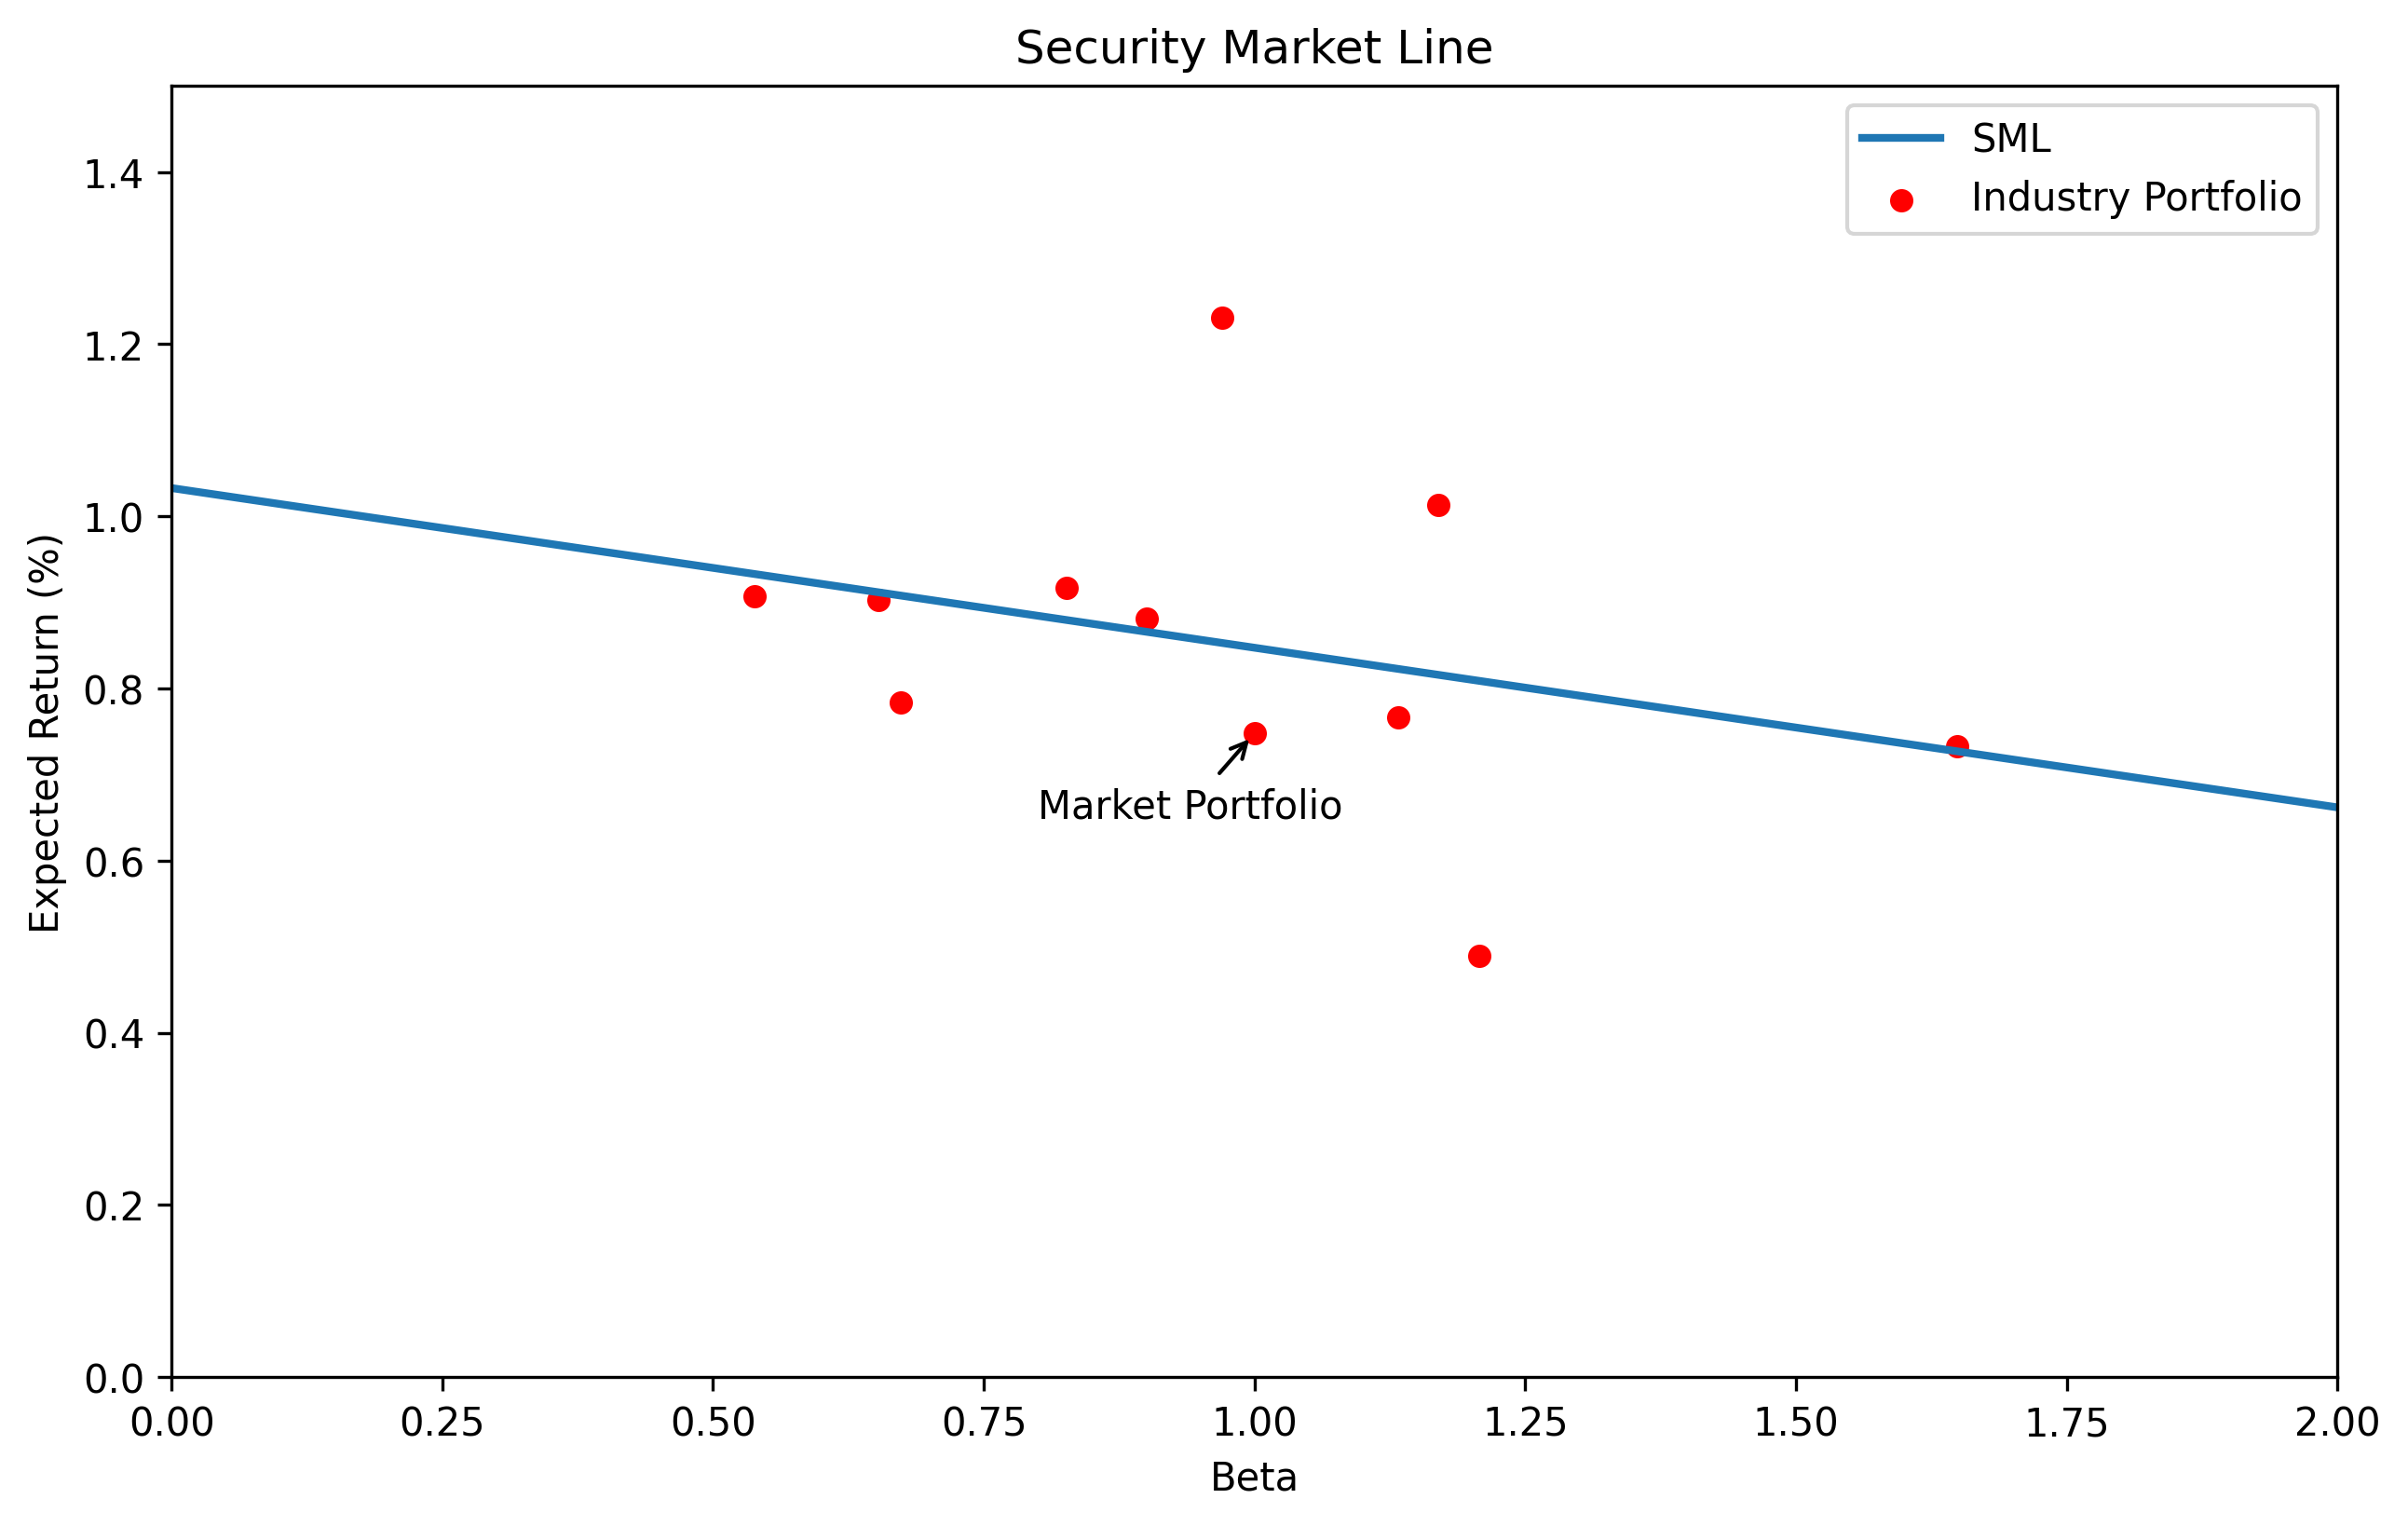

In [80]:
plt.figure(figsize=(10,6),dpi=300)
plt.plot(beta,returnY, label='SML',lw=2)
plt.scatter(coef_df['Slope coefficient (β)'], mean_df['Monthly Mean Return'],label='Industry Portfolio',marker = 'o',s=25,color='red')
plt.annotate('Market Portfolio',(1,0.748083),(0.8,0.65),arrowprops=dict(arrowstyle='->', color='black'))

plt.xlim((0,2))
plt.ylim((0,1.5))

plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.title('Security Market Line')
plt.xlabel('Beta')
plt.ylabel('Expected Return (%)')
plt.legend()

plt.show()

#### The economic significance of the SML.

The SML provides a framework for determining the fair expected return of an asset given its risk.
SML can be used for assessment of investment opportunities. In the above graph, securities where expected return lies above the SML, may be considered undervalued, while those lies below, may be overvalued.